

**CRISP-DM** stands for *cross-industry process for data mining*. 

The [CRISP-DM](http://www.sv-europe.com/crisp-dm-methodology/) methodology provides a structured approach to planning a data mining project. 

This model is an idealised sequence of events. In practice many of the tasks can be performed in a different order and it will often be necessary to backtrack to previous tasks and repeat certain actions. The model does not try to capture all possible routes through the data mining process.

![State](http://www.sv-europe.com/wp-content/uploads/2016/04/Screenshot-2016-04-20-11.58.54.png)
1. Business understanding
2. Data understanding
3. Data preparation
4. Modeling
5. Evaluation
6. Deployment

In [19]:
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline

sns.set_style( 'white' )

In [20]:
train_df = pd.read_csv("../data/titanic_train.csv")
test_df  = pd.read_csv("../data/titanic_test.csv")

fully_df = train_df.append(test_df, ignore_index=True)
# preview the data
fully_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [21]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [22]:
## A heat map of correlation may give us a understanding of which variables are important

def plot_correlation_map(df):
    corr = df.corr()
    _ , ax = plt.subplots(figsize =(12, 10))
    cmap = sns.diverging_palette(220 , 10 , as_cmap = True)
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={'shrink' : .9}, 
        ax=ax, 
        annot = True, 
        annot_kws = {'fontsize' : 12}
    )

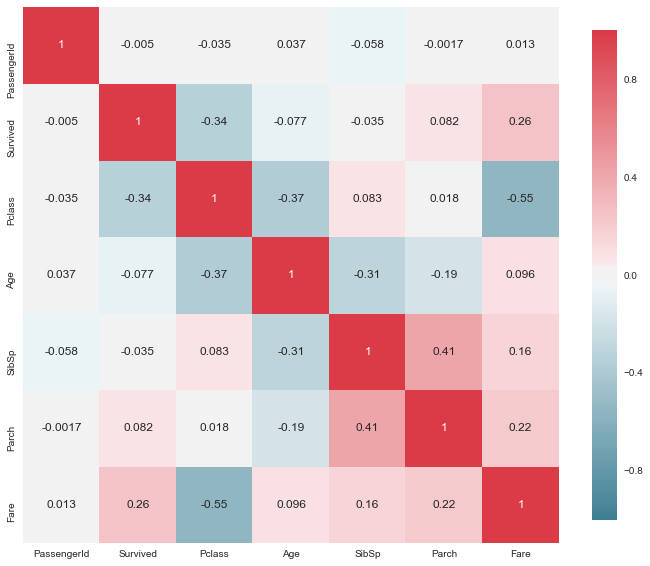

In [23]:
plot_correlation_map(train_df)

In [16]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

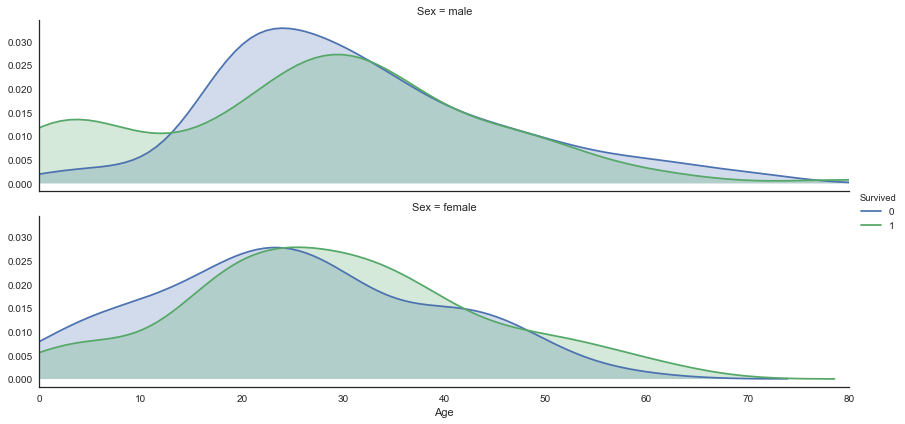

In [17]:
# Plot distributions of Age of passangers who survived or did not survive
plot_distribution(train_df, var = 'Age', target='Survived', row ='Sex')

In [24]:
# Data Cleaning and Features Choosing

# use dummies function to drop out some 
def dummies(col,train,test):
    train_dum = pd.get_dummies(train_df[col])
    test_dum = pd.get_dummies(test_df[col])
    train = pd.concat([train, train_dum], axis=1)
    test = pd.concat([test,test_dum],axis=1)
    train.drop(col,axis=1,inplace=True)
    test.drop(col,axis=1,inplace=True)
    return train, test

# get rid of the useless cols
dropping = ['PassengerId', 'Name', 'Ticket']
train_df.drop(dropping, axis=1, inplace=True)
test_df.drop(dropping, axis=1, inplace=True)

In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 62.7+ KB


3    491
1    216
2    184
Name: Pclass, dtype: int64


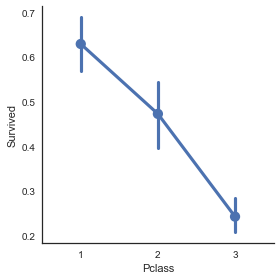

In [26]:
#pclass, no null.
print(train_df.Pclass.value_counts(dropna=False))
sns.factorplot('Pclass', 'Survived',data=train_df, order=[1,2,3])
# according to the graph, we found there are huge differences between
# each pclass group. keep the ft
train_df, test_df = dummies('Pclass', train_df, test_df)

male      577
female    314
Name: Sex, dtype: int64


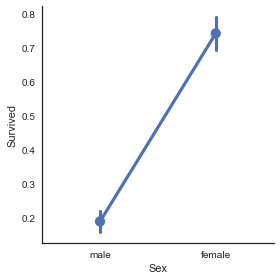

In [32]:
#sex, 
print(train_df.Sex.value_counts(dropna=False))
sns.factorplot('Sex', 'Survived',data=train_df)

In [28]:
# according upper graph, we found there are huge differences between female and male
train_df, test_df = dummies('Sex', train_df, test_df)

In [29]:
train_df.head()

,Survived,Age,SibSp,Parch,Fare,Cabin,Embarked,1,2,3,female,male
0,0,22.0,1,0,7.2500,NaN,S,0,0,1,0,1
1,1,38.0,1,0,71.2833,C85,C,1,0,0,1,0
2,1,26.0,0,0,7.9250,NaN,S,0,0,1,1,0
3,1,35.0,1,0,53.1000,C123,S,1,0,0,1,0
4,0,35.0,0,0,8.0500,NaN,S,0,0,1,0,1


In [31]:
# cos the male survival rate is so low, delete the male col
train_df.drop('male',axis=1,inplace=True)
test_df.drop('male',axis=1,inplace=True)

C:\Users\lpeng\AppData\Local\Continuum\Anaconda3\envs\pml\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\lpeng\AppData\Local\Continuum\Anaconda3\envs\pml\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


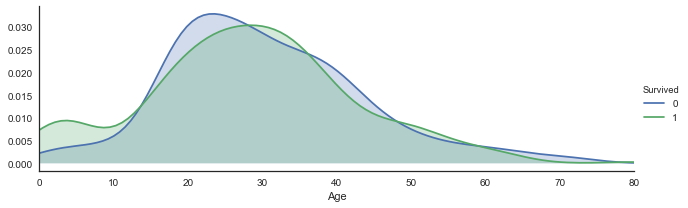

In [33]:
# age
## step1 - adding missing value
#dealing the missing data
nan_num = train_df['Age'].isnull().sum()
# there are 177 missing value, fill with random int
age_mean = train_df['Age'].mean()
age_std = train_df['Age'].std()
filling = np.random.randint(age_mean-age_std, age_mean+age_std, size=nan_num)
train_df['Age'][train_df['Age'].isnull()==True] = filling
nan_num = train_df['Age'].isnull().sum()

# dealing the missing val in test
nan_num = test_df['Age'].isnull().sum()
# 86 null
age_mean = test_df['Age'].mean()
age_std = test_df['Age'].std()
filling = np.random.randint(age_mean-age_std,age_mean+age_std,size=nan_num)
test_df['Age'][test_df['Age'].isnull()==True]=filling
nan_num = test_df['Age'].isnull().sum()

#look into the age col
s = sns.FacetGrid(train_df,hue='Survived',aspect=3)
s.map(sns.kdeplot,'Age',shade=True)
s.set(xlim=(0,train_df['Age'].max()))
s.add_legend()

In [41]:
# from the graph, we see that the survival rate of children
# is higher than other and the 15-30 survival rate is lower
def under15(row):
    result = 0.0
    if row<15:
        result = 1.0
    return result
def young(row):
    result = 0.0
    if row>=15 and row<30:
        result = 1.0
    return result

train['under15'] = train['Age'].apply(under15)
test['under15'] = test['Age'].apply(under15)
train['young'] = train['Age'].apply(young)
test['young'] = test['Age'].apply(young)

train.drop('Age',axis=1,inplace=True)
test.drop('Age',axis=1,inplace=True)

KeyError: 'Age'

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


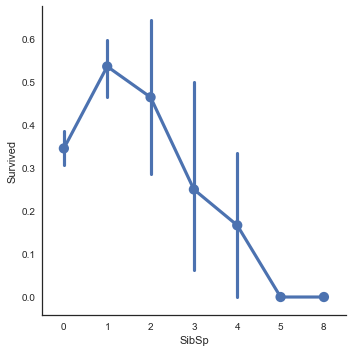

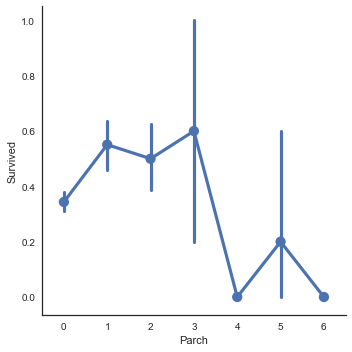

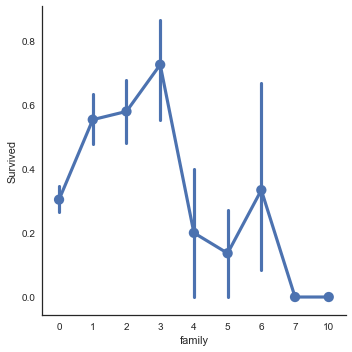

In [39]:
#family
# chek
print(train['SibSp'].value_counts(dropna=False))
print(train['Parch'].value_counts(dropna=False))

sns.factorplot('SibSp','Survived',data=train,size=5)
sns.factorplot('Parch','Survived',data=train,size=5)

'''through the plot, we suggest that with more family member, 
the survival rate will drop, we can create the new col
add up the parch and sibsp to check our theory''' 
train['family'] = train['SibSp'] + train['Parch']
test['family'] = test['SibSp'] + test['Parch']
sns.factorplot('family','Survived',data=train,size=5)

train.drop(['SibSp','Parch'],axis=1,inplace=True)
test.drop(['SibSp','Parch'],axis=1,inplace=True)

In [42]:
train_df.head()

,Survived,Age,SibSp,Parch,Fare,Cabin,Embarked,1,2,3,female,male
0,0,22.0,1,0,7.2500,NaN,S,0,0,1,0,1
1,1,38.0,1,0,71.2833,C85,C,1,0,0,1,0
2,1,26.0,0,0,7.9250,NaN,S,0,0,1,1,0
3,1,35.0,1,0,53.1000,C123,S,1,0,0,1,0
4,0,35.0,0,0,8.0500,NaN,S,0,0,1,0,1


In [3]:
train_df = pd.read_csv("../data/titanic_train.csv")
test_df  = pd.read_csv("../data/titanic_test.csv")

In [6]:
full_data = [train_df, test_df]

print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


In [ ]:
#Feature Engineering

In [8]:
print(train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


In [10]:
print(train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


In [14]:
pd.qcut? #Quantile-based

In [13]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train_df['Fare'].median())
train_df['CategoricalFare'] = pd.qcut(train_df['Fare'], 4)

print(train_df[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())

   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


In [16]:
# Name process
import re

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

print(pd.crosstab(train_df['Title'], train_df['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


In [17]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
    'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print (train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


In [18]:
for dataset in full_data:
    # Mapping Sex
    # Using map to convert nonnumerical paramater to numercial numbers.
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']                               = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare']                                  = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age']                          = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4

# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp',\
                 'Parch', 'FamilySize']
train = train_df.drop(drop_elements, axis = 1)
train = train_df.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)

test  = test.drop(drop_elements, axis = 1)

print(train_df.head(10))

train = train_df.values
test  = test_df.values

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log  = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train[0::, 1::]
y = train[0::, 0]

acc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    if name in acc_dict:
        acc_dict[name] += acc
    else:
        acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")